In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Process Data

In [175]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [176]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


In [177]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

In [178]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [179]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

In [180]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [181]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [182]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sc_x = StandardScaler()
X = sc_x.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

# Logistic Regression
* For Loss function is square error **(output - y)^2**. Also I add **l2 penalty** to prevent model from overfitting
* Activation funtion is **1.0 / (1.0 + np.exp(-x))**
* Predict function is **inner product input data with our pre-trained w**, and throw the result in **activation function**. Finally, use a **threshold 0.5** to transform continuous prediction to binary cas.
* Predict_porba is the predict probability of class 0 or 1, I will need it for plotting ROC curve

In [218]:
class LogisticRegression(object):
    def __init__(self, eta=0.01, n_epoch=1000, random_state=1):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        return ((output-y)**2) + 0.001*self.w_[1:].T.dot(self.w_[1:])

    def activation(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def predict(self, X):
        net_input = self.net_input(X)
        output = self.activation(net_input)
        output[output>0.5] = 1
        output[output<=0.5] = 0
        return output;
    def predict_proba(self, X):
        net_input = self.net_input(X)
        output1 = self.activation(net_input)
        output0 = 1 - self.activation(net_input)
        out = np.vstack([output0, output1])
        return np.transpose(out)

# Confusion Matrix

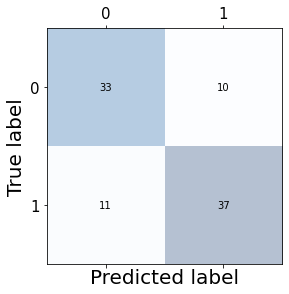

In [219]:
from sklearn.metrics import confusion_matrix
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

# ROC Curve

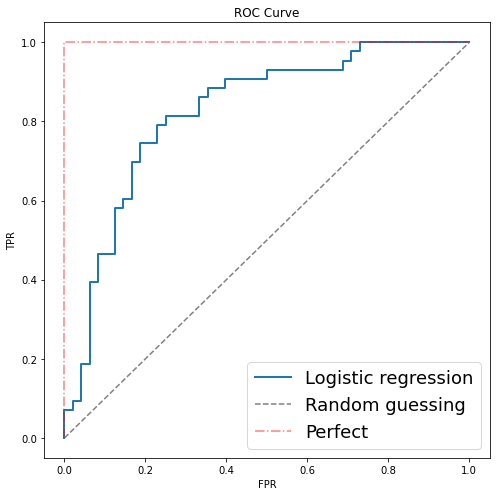

AUC: 0.82


In [221]:
from sklearn import metrics
fig = plt.figure(figsize=(7,7))

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

model = LogisticRegression()
model.fit(X_train, y_train)
probas = model.predict_proba(X_test) 
## we use feature 1 as positive label
fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)

plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

print('AUC: %.2f' % metrics.auc(fpr, tpr))